# Chapter 3 분류

## 3.1 MNIST

MNIST는 손글씨 70000개로 이루어진 데이터 셋이며 각 이미지에는 어떤 숫자를 나타내는지 레이블 되어 있다.
이는 머신러닝의 "Hello World"라고 불린다.

In [1]:
# 데이터 다운 받자!
from sklearn.datasets import fetch_openml

mnist = fetch_openml('mnist_784', version=1)
mnist.keys()

dict_keys(['data', 'target', 'frame', 'categories', 'feature_names', 'target_names', 'DESCR', 'details', 'url'])

사이킷런에서 읽어 들인 데이터셋들은 일반적으로 비슷한 딕셔너리 구조를 가지고 있다.

- 데이터셋을 설명하는 DESCR 키
- 샘플이 하나의 행, 특성이 하나의 열로 구성된 배열을 가진 data 키
- 레이블 배열으 담은 target 키

In [2]:
# 데이터를 살펴보자!

X, y = mnist["data"], mnist["target"]
X.shape, y.shape

((70000, 784), (70000,))

이미지가 7만개 있고, 각 이미지에는 784개의 특성이 있다. 이는 이미지가 28x28 픽셀이기 때문이다.

개개의 특성은 0(흰색) ~ 255(검은색) 까지의 픽셀 강도를 나타낸다.

이미지 데이터 중 하나를 확인해보자.

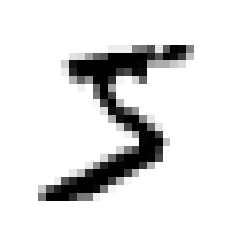

In [3]:
import matplotlib as mpl
import matplotlib.pyplot as plt

some_digit = X[0]
some_digit_image = some_digit.reshape(28, 28)

plt.imshow(some_digit_image, cmap="binary")
plt.axis("off")
plt.show()

숫자 5처럼 보인다. 레이블 값도 확인해보자.

In [4]:
y[0], type(y[0])

('5', str)

레이블이 문자열이다. 대부분 머신러닝 알고리즘은 숫자를 기대하므로 y를 정수로 변환하자.

In [5]:
import numpy as np

y = y.astype(np.uint8)
type(y[0])

numpy.uint8

이제 본격적으로 데이터를 자세히 조사하기 전에 항상 테스트 세트를 만들고 따로 떼어놓아야 한다.

In [6]:
X_train, X_test, y_train, y_test = X[:60000], X[60000:], y[:60000], y[60000:]

MNIST 데이터의 경우 훈련 세트가 이미 잘 섞여있어서 교차 검증 폴드를 비슷하게 만든다. 데이터 셋이 이렇게 미리 섞여 있으면 훈련 샘플의 순서에 민감한 알고리즘 등에도 해당 문제를 방지할 수 있다.

## 3.2 이진 분류기 훈련

문제를 단순화해서 하나의 숫자, 예를 들어 숫자 5만 식별해보도록 하자.

그렇게 되면 이 문제는 레이블이 5가 맞음, 5가 아님 두 개의 클래스를 구분할 수 있는 이진 분류기(binary classifier)의 한 예시이다.

분류 작업을 위해 타깃 벡터를 만들자.

In [7]:
y_train_5 = (y_train == 5)
y_test_5 = (y_test == 5) # 5는 True, 나머지는 False

이제 분류 모델을 하나 선택해서 훈련시키자.

사이킷런의 SGDClassifier 클래스를 사용해 확률적 경사 하강법(stochastic Gradient Descent, SGD) 분류기로 시작해보자. 이는 매우 큰 데이터셋을 효율적으로 처리하는 장점을 가지고 있다.

SGD가 한 번에 하나씩 훈련 샘플을 독립적으로 처리하기 때문이다.

아무튼 SGDClassifier 모델을 만들고 전체 훈련 세트를 사용해 훈련시켜보자.

In [8]:
from sklearn.linear_model import SGDClassifier

sgd_clf = SGDClassifier(random_state=42)
sgd_clf.fit(X_train, y_train_5)

SGDClassifier(random_state=42)

이제 이 모델을 사용해 숫자 5의 이미지를 감지해보자.

In [9]:
sgd_clf.predict([some_digit]) # 아까 위에서 본 숫자 5 이미지

array([ True])

이 케이스의 경우에는 정답을 내놓았다. 이제 모델의 성능을 평가해보자.

## 3.3 성능 측정

분류기 평가는 회귀 모델보다 훨씬 어렵다. 따라서 설명할 내용도 많고, 사용할 수 있는 성능 지표도 많다.

### 3.3.1 교차 검증을 사용한 정확도 측정

2장에서 미리 본 것처럼 교차 검증은 모델을 평가하는 좋은 방법이다.

#### 교차 검증 구현

가끔 사이킷런이 제공하는 기능보다 교차 검증 과정을 더 많이 제어할 필요가 있는 경우가 있다. 이 때는 교차 검증을 직접 구현해야 한다. 다음 코드는 사이킷런의 cross_val_score() 함수와 거의 같은 작업을 수행하고 동일한 결과르 출력한다.

In [10]:
from sklearn.model_selection import StratifiedKFold
from sklearn.base import clone

skfolds = StratifiedKFold(n_splits=3, random_state=42, shuffle=True)

for train_index, test_index in skfolds.split(X_train, y_train_5) :
    clone_clf = clone(sgd_clf)
    
    X_train_folds = X_train[train_index]
    y_train_folds = y_train_5[train_index]
    X_test_fold = X_train[test_index]
    y_test_fold = y_train_5[test_index]
    
    clone_clf.fit(X_train_folds, y_train_folds)
    y_pred = clone_clf.predict(X_test_fold)
    n_correct = sum(y_pred==y_test_fold)
    print(n_correct/len(y_pred))

0.9669
0.91625
0.96785


아무튼 cross_val_score()를 이용해서도 한 번 확인해 보자. k 폴드 교차 겁증은 훈련 세트를 k개의 폴드로 나누고 각 폴드에 대해 예측을 만들고 평가하기 위해 나머지 폴드로 훈련시킨 모델을 사용한다는 사실을 기억하자.

In [11]:
from sklearn.model_selection import cross_val_score

cross_val_score(sgd_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.95035, 0.96035, 0.9604 ])

교차 검증에 대해 정확도가 95% 이상이다. 

일단, 흥분하지 말고 모든 이미지를 '5 아님' 클래스로 분류하는 더미 분류기를 만들어 비교해보자.

In [12]:
from sklearn.base import BaseEstimator

class Never5Classifier(BaseEstimator) :
    def fit(self, X, y=None) :
        return self
    def predict(self, X) :
        return np.zeros((len(X), 1), dtype=bool)

In [13]:
never_5_clf = Never5Classifier()
cross_val_score(never_5_clf, X_train, y_train_5, cv=3, scoring="accuracy")

array([0.91125, 0.90855, 0.90915])

무조건 5가 아니라고 예측했음에도 정확도가 모두 90% 이상으로 나왔다.

이는 정확도를 분류기의 성능 지표로 선호되지 않는 이유를 보여준다.

특히 불균형한 데이터셋을 다룰 때 더욱 그렇다.

### 3.3.2 오차 행렬

분류기의 성능을 평가하는 더 좋은 방법은 오차 행렬(confusion matrix)을 조사하는 것이다. 기본적인 아이디어는 클래스 A의 샘필이 클래스 B로 분류된 횟수를 세는 것이다.

예를 들어 분류기가 숫자 5의 이미지를 숫자 3으로 잘못 분류한 횟수를 알고 싶다면 오차 행렬의 5행 3열을 보면 된다.

오차 행렬을 만들려면 실제 타깃과 비교할 수 있도록 예측값을 먼저 만들어야 한다. 테스트 세트로 예측을 만들 수 있지만 여기서 사용하면 안된다. 대신 cross_val_predict()함수를 사용할 수 있다.

이는 cross_val_score() 함수처럼 k 폴드 교차 검증을 수행하지만, 평가 점수를 반환하는 것이 아닌 각 테스트 폴드에서 얻은 예측을 반환한다.

confusion_matrix() 함수까지 사용해 오차 행렬을 만들어보자.

In [14]:
from sklearn.model_selection import cross_val_predict
from sklearn.metrics import confusion_matrix

y_train_pred = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3)
confusion_matrix(y_train_5, y_train_pred)

array([[53892,   687],
       [ 1891,  3530]], dtype=int64)

오차 행렬의 행은 실제 클래스를 나타내고 열은 예측한 클래스를 나타낸다.

완벽한 분류기일 경우 왼쪽 상단 - 오른쪽 하단 대각선만 0이 아닌 수가 된다.

오차행렬이 많은 정보를 제공해주지만 가끔 더 요약된 지표가 필요한 경우가 있다.

먼저 양성 예측의 정확도를 살펴보자. 이를 정밀도라고 한다.

정밀도 = TP/(TP+FP)

TP는 진짜 양성의 수이고, FP는 거짓 양성의 수이다.

분류기가 양성으로 판단한 것 중 올바른 판단은 얼마나 되는지 계산한다.

일반적으로 정밀도는 재현율이라는 다른 지표와 같이 사용한다. 

재현율은 분류기가 정확하게 감지한 양성 샘플의 비율로 민감도 또는 진짜 양성 비율이라고 한다.

재현율 = TP/(TP+FN)

FN은 거짓 음성의 수이다.

### 3.3.3 정밀도와 재현율

사이킷런은 정밀도와 재현율을 포함하여 분류기의 지표를 계산하는 여러 함수를 제공한다.

In [15]:
from sklearn.metrics import precision_score, recall_score

precision_score(y_train_5, y_train_pred)

0.8370879772350012

In [16]:
recall_score(y_train_5, y_train_pred)

0.6511713705958311

분류기가 판별한 5 이미지 중 83%만 정확하다. 또, 전체 5 이미지 중에서 65%만 정확하게 감지했다.

정밀도와 재현율을 F1점수로 하나의 숫자로 만들면 편리할 때가 많은데, 특히 두 분류기를 비교할 때 그렇다.

F1점수, F1 score는 정밀도와 재현율의 조화 평균이다.

F1 = 2 / (1/정밀도 + 1/재현율) = TP/(TP + (FN+FP)/2)

사이킷런에서 f1_score() 함수로 제공한다.

In [17]:
from sklearn.metrics import f1_score

f1_score(y_train_5, y_train_pred)

0.7325171197343846

정밀도와 재현율이 비슷한 분류기에서는 F1 점수가 높다. 하지만 이것이 항상 바람직한 것은 아닌데, 상황에 따라 정밀도가 중요할 수도 있고, 재현율이 중요할 수도 있다.

아무튼 이 둘을 모두 얻을 수는 없다. 이를 정밀도/재현율 트레이드 오프라고 한다.

### 3.3.4 정밀도/재현율 트레이드 오프

SGDClassifier가 분류를 어떻게 결정하는지 살펴보며 이 트레이드 오프를 이해해보자.

이 분류기는 결정함수(decision function)을 사용하여 각 샘플의 점수를 계산한다. 이 점수가 임곗값보다 크면 샘플을 양성 클래스에 할당하고 그렇지 않으면 음성 클래스에 할당한다.

그림 설명은 패스

아무튼 진짜 각 데이터가 어떤 클래스에 대해 높은 확률로 분류되는 순서로 데이터를 나열했을 때, 이 나열된 데이터의 실제 레이블은 약간씩 섞여있다. 

따라서 어느 지점을 임계값으로 하느냐에 따라 정밀도가 높아지면 재현율이 줄어드는 현상이 발생한다.

SGDClassifier의 predict()대신 decision_function() 메서드를 호출하면 각 샘플의 점수를 얻을 수 있다.

이를 기반으로 원하는 임곗값을 정해 예측을 만들어보자.

In [18]:
y_scores = sgd_clf.decision_function([some_digit])
y_scores

array([2164.22030239])

In [19]:
threshold = 0
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([ True])

In [20]:
threshold = 8000
y_some_digit_pred = (y_scores > threshold)
y_some_digit_pred

array([False])

이 결과는 임곗값을 높이면 재현율이 줄어든다는 것을 보여준다.

어떻게 적절한 임곗값을 설정할 수 있을까?

일단 먼저 cross_val_predict() 함수를 사용해 훈련 세트에 있는 모든 샘플의 점수를 구해야 한다.

하지만 이번에는 예측 결과가 아니라 결정 점수를 반환받도록 지정하자.

In [22]:
y_scores = cross_val_predict(sgd_clf, X_train, y_train_5, cv=3,
                             method="decision_function")

이 점수로 precision_recall_curve() 함수를 사용하여 가능한 모든 임곗값에 대해 정밀도와 재현율을 계산할 수 있다.

In [24]:
from sklearn.metrics import precision_recall_curve

precision, recalls, thresholds = precision_recall_curve(y_train_5, y_scores)

C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51221 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 48128 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 46020 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 51116 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 54788 missing from current font.
  font.set_text(s, 0.0, flags=flags)
C:\Users\korea_1\anaconda3\lib\site-packages\matplotlib\backends\backend_agg.py:214: RuntimeWarning: Glyph 50984 mi

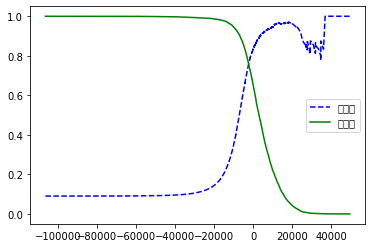

In [27]:
def plot_precision_recall_vs_threshold(precisions, recalls, thresholds) :
    plt.plot(thresholds, precisions[:-1], "b--", label="정밀도")
    plt.plot(thresholds, recalls[:-1], "g-", label="재현율")
    plt.legend()

plot_precision_recall_vs_threshold(precision, recalls, thresholds)
plt.show()

보통 재현율이 급격하게 줄어드는 하강점 직전을 정밀도/재현율 트레이드 오프로 선택하는 것이 좋다. 재현율이 60퍼센트 부근이다. 

만약 90%의 정밀도를 달성하는 것이 목표라면, 그 중에서도 가장 낮은 임곗값을 찾을 수 있다.

In [29]:
threshold_90_precision = thresholds[np.argmax(precision > 0.90)]
y_train_pred_90 = (y_scores >= threshold_90_precision)

In [30]:
precision_score(y_train_5, y_train_pred_90)

0.9000345901072293

In [31]:
recall_score(y_train_5, y_train_pred_90)

0.4799852425751706

### 3.3.5 ROC 곡선

수신기 조작 특성(receiver operation characteristic, ROC) 곡선도 이진 분류에서 널리 사용하는 도구이다. 이는 거짓 양성 비율(FPR)에 대한 진짜 양성 비율(TPR, 재현율의 다른 이름)의 곡선이다.

양성으로 잘못 분류된 음성 샘플의 비율이 FPR이다. 이는 1에서 음성으로 정확하게 분류한 음성 샘플의 비율인 진짜 음성 비율(TNR)을 뺀 값이다. 이를 특이도라고도 하는데 따라서 ROC 곡선은 민감도에 대한 1-특이도 그래프이다.

In [32]:
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_train_5, y_scores)

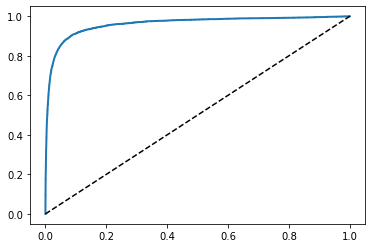

In [33]:
def plot_roc_curve(fpr, tpr, label=None) :
    plt.plot(fpr, tpr, linewidth=2, label=label)
    plt.plot([0, 1], [0, 1], 'k--')
    
plot_roc_curve(fpr, tpr)
plt.show()